In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, mm, np
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from numba import njit, prange
import numba
%matplotlib ipympl

Text(0.5, 0, 'Distance')

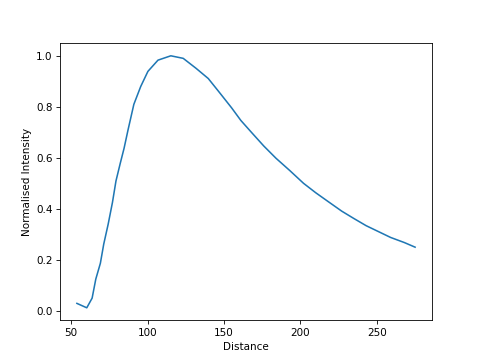

In [2]:
xy_extracted = np.array([[3.75e+00, 3.10e-02],
       [1.02e+01, 1.37e-02],
       [1.37e+01, 5.15e-02],
       [1.61e+01, 1.26e-01],
       [1.91e+01, 1.88e-01],
       [2.13e+01, 2.63e-01],
       [2.42e+01, 3.41e-01],
       [2.70e+01, 4.26e-01],
       [2.93e+01, 5.10e-01],
       [3.21e+01, 5.79e-01],
       [3.46e+01, 6.38e-01],
       [3.72e+01, 7.10e-01],
       [4.10e+01, 8.10e-01],
       [4.55e+01, 8.80e-01],
       [5.02e+01, 9.39e-01],
       [5.68e+01, 9.83e-01],
       [6.52e+01, 1.00e+00],
       [7.33e+01, 9.90e-01],
       [8.17e+01, 9.51e-01],
       [8.97e+01, 9.11e-01],
       [9.68e+01, 8.58e-01],
       [1.05e+02, 7.96e-01],
       [1.11e+02, 7.47e-01],
       [1.18e+02, 7.00e-01],
       [1.26e+02, 6.47e-01],
       [1.34e+02, 5.99e-01],
       [1.43e+02, 5.51e-01],
       [1.52e+02, 5.01e-01],
       [1.60e+02, 4.64e-01],
       [1.68e+02, 4.30e-01],
       [1.77e+02, 3.92e-01],
       [1.85e+02, 3.63e-01],
       [1.93e+02, 3.35e-01],
       [2.01e+02, 3.12e-01],
       [2.09e+02, 2.89e-01],
       [2.18e+02, 2.69e-01],
       [2.25e+02, 2.51e-01]])

plt.figure()
plt.plot(xy_extracted[:, 0] + 50, xy_extracted[:, 1])
plt.ylabel('Normalised Intensity')
plt.xlabel('Distance')

Functions for diffractio rayleigh sommerfeld FFT method

In [3]:
def diffractio_rs_pt_source_1D(x0, 
                                z_prop,
                                wavelength,
                                draw_inputs=False,
                                amplitude=1.0):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.spherical_wave(A=amplitude,x0=0, z0=0, normalize=True)
    u0.u = u0.u*amplitude
    
    z = z_prop
    u1 = u0.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='phase')
        u1.draw(kind='phase')
        
        u0.draw(kind='amplitude')
        u1.draw(kind='amplitude')

    return u1


def diffractio_rs_aperture_1D(x0, 
                           z_prop,
                           aperture_width, 
                           wavelength,
                           draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_X(x0, wavelength)
    t0.slit(x0=0, size=aperture_width*um)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw()
        t0.draw()

    return u2

def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.slit(x0=0, size=aperture_width*um, angle=0)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2

Main monte carlo function: There are two options, with plane wave approximation, whereby each ray is assumed to be a plane wave, and thus can affect every pixel on the detector, or without plane wave approxitation, where the each ray affects only one pixel on the detector. See the notebook "PlaneWaveVectorDisplay" to see what vectors must be calculated to shift the wavefront correctly onto the detector. To include phase shifts from a sample, the sample phase shifts array is just the potential times the interaction constant from abtem. Otherwise, if it is an aperture, this is just an array of 1+0j complex numbers the same shape as the aperture as no phase shift is applied by the aperture. 

In [4]:

def monte_carlo_diffraction(num_rays, 
                            final_image,
                            pixel_size,
                            sample_yx_coords,
                            det_yx_coords,
                            sample_phase_shifts,
                            z_prop,
                            wavelength,
                            ):
    
    y_sam = sample_yx_coords.shape[1]
    x_sam = sample_yx_coords.shape[2]

    y_det = det_yx_coords.shape[1]
    x_det = det_yx_coords.shape[2]
    
    # Get random pixel samples of the sample (or aperture) and the detector
    random_sample_coord_idx_x = np.random.randint(x_sam, size = num_rays)
    random_sample_coord_idx_y = np.random.randint(y_sam, size = num_rays)
    
    random_detector_coord_idx_x = np.random.randint(x_det, size = num_rays)
    random_detector_coord_idx_y = np.random.randint(y_det, size = num_rays)
    
    random_sample_coord_yx = sample_yx_coords[:, random_sample_coord_idx_y, random_sample_coord_idx_x]
    sample_phase_shift = sample_phase_shifts[random_sample_coord_idx_y, random_sample_coord_idx_x]
    random_detector_coord_yx = det_yx_coords[:, random_detector_coord_idx_y, random_detector_coord_idx_x]

    # Calculate distance between pixel chosen in sample and detector
    x_dist = random_sample_coord_yx[1, :] - random_detector_coord_yx[1, :]
    y_dist = random_sample_coord_yx[0, :] - random_detector_coord_yx[0, :]
    
    distance = np.sqrt(x_dist ** 2 + y_dist ** 2 + z_prop ** 2)
    ray_dir_cosine = z_prop / distance

    # See Chapter 2 of Marco Mout thesis - 2.97 onwards
    wi = np.sqrt(1 / ray_dir_cosine) * ray_dir_cosine
    
    num_rays_per_pixel_samp = num_rays / ((y_sam * x_sam) * pixel_size)
    num_rays_per_pixel_det = num_rays / ((y_det * x_det) * pixel_size)
    ws = np.sqrt((num_rays * pixel_size) /  num_rays_per_pixel_samp)  
    wp = np.sqrt((num_rays * pixel_size) / num_rays_per_pixel_det)  
        
    # Find phase of wavefront at randomly selected detector pixel, and also the phase shift of the sample
    distance_phase = np.exp(1j * distance * ((2 * np.pi) / wavelength))  * (1 / distance)
    sample_phase = np.exp(1j * (sample_phase_shift))
    
    # Add complex wavefront to each pixel in the image - the extra amplitude factors in this function at the end are to try and approximate the RS
    # diffraction integral for a single ray, but mainly they are here because I don't understand Marco Mouts intensity calculation. By including these factors
    # we correctly estimate the shape of the diffraction pattern when I look at it in a plane near the aperture. 
    complex_rays =  wi * ws * wp * distance_phase
    np.add.at(final_image, (random_detector_coord_idx_y, random_detector_coord_idx_x), complex_rays)
        
    return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)



In [5]:
import cupy as cp

mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=18*1024**3)  # 10 GiB

def monte_carlo_diffraction_cupy(num_rays, 
                                 final_image_real,
                                 final_image_imag,
                                 pixel_size,
                                 samp_yx,
                                 det_yx,
                                 s_p_s,
                                 z_prop,
                                 wavelength,
                                 batch_size=int(1e7)):  # Batch size set to 100 million
    
    y_sam = samp_yx.shape[1]
    x_sam = samp_yx.shape[2]
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]
    
    for start_idx in range(0, num_rays, batch_size):
        end_idx = min(start_idx + batch_size, num_rays)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the sample (or aperture) and the detector
        rand_samp_idx_x = cp.random.randint(x_sam, size=current_batch_size)
        rand_samp_idx_y = cp.random.randint(y_sam, size=current_batch_size)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        samp_x = samp_yx[:, rand_samp_idx_y, rand_samp_idx_x][1, :]
        samp_y = samp_yx[:, rand_samp_idx_y, rand_samp_idx_x][0, :]
        samp_z = cp.zeros(current_batch_size)
        
        det_x = det_yx[:, rand_det_idx_y, rand_det_idx_x][1, :]
        det_y = det_yx[:, rand_det_idx_y, rand_det_idx_x][0, :]
        det_z = cp.ones(current_batch_size) * z_prop
        
        ray_samp_coord = cp.array([samp_z, samp_y, samp_x])   
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        ray = ray_det_coord - ray_samp_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)
        ray_direction = ray / ray_magnitude
        
        samp_v = cp.array([1, 0, 0])
        det_v = cp.array([1, 0, 0])
    
        distance = cp.sqrt((samp_y - det_y) ** 2 + 
                           (samp_x - det_x) ** 2 + 
                           z_prop ** 2)
        
        ray_dir_cosine = z_prop / distance
        
        # See Chapter 2 of Marco Mout thesis - 2.97 onwards
        wi = np.sqrt(1 / cp.dot(ray_direction.T, det_v)) * cp.dot(ray_direction.T, det_v)
        
        num_rays_per_pixel_samp = num_rays / ((y_sam * x_sam) * pixel_size)
        num_rays_per_pixel_det = num_rays / ((y_det * x_det) * pixel_size)
        
        ws = np.sqrt((num_rays * pixel_size) / num_rays_per_pixel_samp)  
        wp = np.sqrt((num_rays * pixel_size) / num_rays_per_pixel_det)

        # Calculate phase and amplitude factors
        phase = cp.exp(1j * distance * ((2 * cp.pi) / wavelength)) * cp.exp(1j * (s_p_s[rand_samp_idx_y, rand_samp_idx_x]))
        amplitude = wi * ws * wp
        complex_rays = amplitude * phase

        # Add complex wavefront to each pixel in the image
        cp.add.at(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cp.add.at(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)

    final_image = final_image_real + 1j * final_image_imag
    return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)

In [6]:
# @njit(parallel=True, fastmath=True, inline='always')
# def monte_carlo_diffraction(num_rays, 
#                             final_image,
#                             pixel_size,
#                             sample_yx_coords,
#                             det_yx_coords,
#                             sample_phase_shifts,
#                             z_prop,
#                             wavelength,
#                             ):
    
#     y_sam = sample_yx_coords.shape[1]
#     x_sam = sample_yx_coords.shape[2]

#     y_det = det_yx_coords.shape[1]
#     x_det = det_yx_coords.shape[2]
    
#     random_sample_coord_idx_x = np.random.randint(0, x_sam, size=num_rays)
#     random_sample_coord_idx_y = np.random.randint(0, y_sam, size=num_rays)

#     random_detector_coord_idx_x = np.random.randint(0, x_det, size=num_rays)
#     random_detector_coord_idx_y = np.random.randint(0, y_det, size=num_rays)
#     # Initialize the array to store the coordinates
    
#     random_sample_coord_yx = np.empty((2, num_rays), dtype=sample_yx_coords.dtype)
#     random_detector_coord_yx = np.empty((2, num_rays), dtype=det_yx_coords.dtype) 
#     sample_phase_shift = np.empty((1, num_rays), dtype=sample_phase_shifts.dtype)

#     # Loop over the number of rays and populate the new array
#     for i in range(num_rays):
#         random_sample_coord_yx[0, i] = sample_yx_coords[0, random_sample_coord_idx_y[i], random_sample_coord_idx_x[i]]
#         random_sample_coord_yx[1, i] = sample_yx_coords[1, random_sample_coord_idx_y[i], random_sample_coord_idx_x[i]]
#         random_detector_coord_yx[0, i] = det_yx_coords[0, random_detector_coord_idx_y[i], random_detector_coord_idx_x[i]]
#         random_detector_coord_yx[1, i] = det_yx_coords[1, random_detector_coord_idx_y[i], random_detector_coord_idx_x[i]]
#         sample_phase_shift[0, i] = sample_phase_shifts[random_sample_coord_idx_y[i], random_sample_coord_idx_x[i]]

#     # Calculate distance between pixel chosen in sample and detector
#     x_dist = random_sample_coord_yx[1, :] - random_detector_coord_yx[1, :]
#     y_dist = random_sample_coord_yx[0, :] - random_detector_coord_yx[0, :]
    
#     distance = np.sqrt(x_dist ** 2 + y_dist ** 2 + z_prop ** 2)
#     ray_dir_cosine = z_prop / distance

#     # See Chapter 2 of Marco Mout thesis - 2.97 onwards
#     wi = np.sqrt(1 / ray_dir_cosine) * ray_dir_cosine
    
#     num_rays_per_pixel = num_rays / (y_sam * x_sam)
    
#     ws = np.sqrt((num_rays * pixel_size))  
#     wp = 1
        
#     # Find phase of wavefront at randomly selected detector pixel, and also the phase shift of the sample
#     distance_phase = np.exp(1j * distance * ((2 * np.pi) / wavelength))  * (1 / distance)
#     sample_phase = np.exp(1j * (sample_phase_shift))
    
#     # Add complex wavefront to each pixel in the image - the extra amplitude factors in this function at the end are to try and approximate the RS
#     # diffraction integral for a single ray, but mainly they are here because I don't understand Marco Mouts intensity calculation. By including these factors
#     # we correctly estimate the shape of the diffraction pattern when I look at it in a plane near the aperture. 
#     complex_rays =  wi * ws * wp * distance_phase
#     # np.add.at(final_image, (random_detector_coord_idx_y, random_detector_coord_idx_x), complex_rays)
    
#     for i in prange(num_rays):
#         # Get the indices for the detector
#         y_idx = random_detector_coord_idx_y[i]
#         x_idx = random_detector_coord_idx_x[i]

#         # Add the complex ray value to the final image at the specified indices
#         final_image[y_idx, x_idx] += complex_rays[i]
        
#     return final_image * (1 / (num_rays * pixel_size)) * (-1j / wavelength)



Try and recreate plane wave to begin with: Can we initiate a plane wave source with an intensity and E field of 1, propagate it some distance, and recreate an intensity and e field of 1?

In [7]:
aperture_diameter = 1000 * um
detector_width_x = 1000 * um
detector_width_y = 0 * um

num_px_det_x = 100
num_px_det_y  = 1
num_px_samp_x = 1
num_px_samp_y = 1

detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x )).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 

sample_yx_coords = np.array([[0, 0]])
sample_idx_start_yx = np.array([0, 0])

det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)
sample_yx_coords = sample_yx_coords.T.reshape(2, num_px_samp_y, num_px_samp_x)

z_prop = 5000 * um
wavelength = 0.638 * um

In [8]:
u2 = diffractio_rs_pt_source_1D(x0=det_yx_coords[1, 0, :], 
                                z_prop=z_prop, 
                                wavelength=wavelength, 
                                draw_inputs=False,
                                amplitude=1)

r = np.sqrt(det_yx_coords[1, 0, :]**2 + z_prop**2)
k = (2 * np.pi) / wavelength
#analytic_point_source = 1.0 * np.exp(1j * k * r) / (2 * np.pi * r) * ((z_prop) / r) * ((1 / r) - 1j * k)
analytic_point_source = 1  / (1 * r) * ((z_prop) / r) * ( - 1j * (1 / wavelength))

- Needs denser sampling: factor 0.32


In [11]:
num_rays=int(1e9)
planewaveapprox=False
final_image = np.zeros([num_px_det_y, num_px_det_x], dtype = np.complex128)
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
sample_yx_coords = cp.asarray(sample_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
aperture_phase_shifts = cp.zeros_like(final_image, dtype=cp.complex128)

final_image = monte_carlo_diffraction_cupy(num_rays, final_image_real, final_image_imag, detector_px_width_x,sample_yx_coords,det_yx_coords,aperture_phase_shifts,z_prop,wavelength)
det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

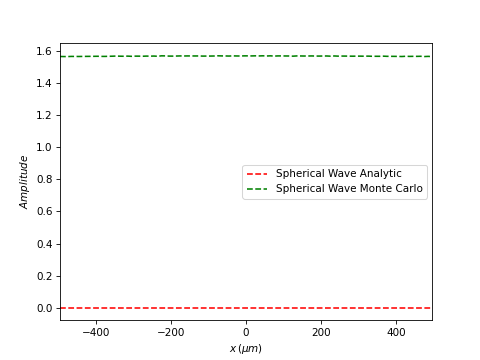

In [10]:

fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Amplitude$')
ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax.plot(det_yx_coords[1, 0, :], np.abs(analytic_point_source), '--r', label='Spherical Wave Analytic')
ax.plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]), '--g', label='Spherical Wave Monte Carlo')
# ax.plot(det_yx_coords[1, 0, :], np.abs(u2.u), '-k', label='Spherical RS')
plt.legend()

mempool.free_all_blocks()
# fig, ax = plt.subplots()
# ax.set_xlabel('$x\,(\mu m)$')
# ax.set_ylabel('$Phase$')
# ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
# ax.set_ylim(bottom=0)
# ax.plot(det_yx_coords[1, 0, :], np.angle(analytic_point_source), '-r', label='Spherical Wave Analytic')
# ax.plot(det_yx_coords[1, 0, :], np.angle(final_image[0, :]), '--g', label='Spherical Wave Monte Carlo')
# # ax.plot(det_yx_coords[1, 0, :], np.angle(u2.u), '-k', label='Spherical RS')

# plt.legend()

1D Aperture test - try and calculate the diffraction pattern some distance z after the aperture. 

In [48]:
aperture_diameter = 1000 * um
detector_width_x = 1000 * um
detector_width_y = 0 * um

num_px_x = 1000
num_px_y = 1
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128)
print(final_image.shape)

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 

# det_yy, det_xx = np.meshgrid(det_yx_coords[:, 0], det_yx_coords[:, 1])

sample_yx_coords = det_yx_coords[abs(det_yx_coords[:, 1]) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)
sample_idx_start_yx = np.array([0, np.argmax(abs(det_yx_coords[:, 1]) < aperture_diameter/2)])

det_yx_coords = det_yx_coords.T.reshape(2, num_px_y, num_px_x)
sample_yx_coords = sample_yx_coords.T.reshape(2, num_px_y, sample_yx_coords.shape[0])

z_prop = 5 * mm
wavelength = 0.638 * um

print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

(1, 1000)
Fresnel Number =  6.269592476489028e-05


In [49]:
num_rays=int(1e7)
planewaveapprox=False
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128)

final_image = monte_carlo_diffraction(num_rays, 
                                      final_image,
                                      detector_px_width_x,
                                      sample_yx_coords,
                                      det_yx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength)

Show initial field, aperture, and calculate the diffracted field some distance z after the aperture using the Hankel Transform in diffractio. 

Good result: factor 3.19


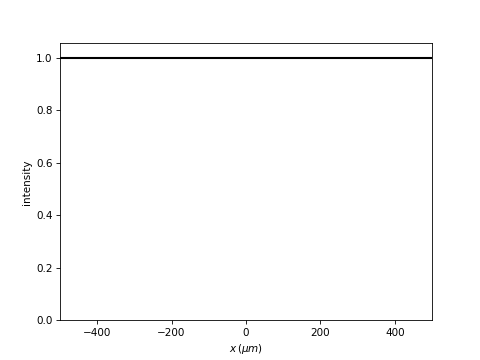

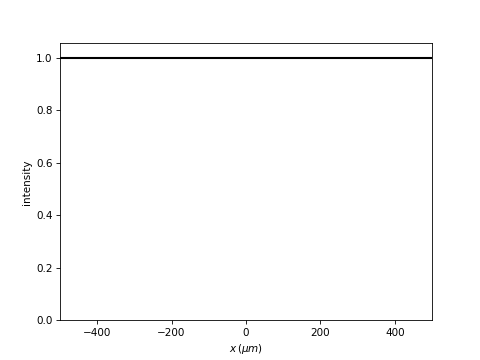

In [ ]:
u2 = diffractio_rs_aperture_1D(x0=det_yx_coords[1, 0, :], 
                            z_prop=z_prop, 
                            aperture_width=aperture_diameter, 
                            wavelength=wavelength, 
                            draw_inputs=True)

Explanation of how monte carlo method works: The Huygens Fresnel Principle states that every point on a wavefront is itself the source of spherical wavelets (See image below). The Rayleigh Sommerfeld diffraction integral is a mathematical description of this principle. We can exploit the Huygens Fresnel principle in regions where geometrical optics breaks down (such as at an aperture or in a thin sample) to continue to propagate rays which also carry information about an aperture or sample. By sampling random directions on each spherical wavefront at a "diffracting surface" and propagating rays forward we can perform a "monte carlo integration" solution to the rayleigh sommerfeld diffraction integral, which allows us to circumvent the use of Fourier methods to solve this diffraction integral, enabling us to more easily integrate wavefront propagation in the context of real microscope components that span large distances. The drawback of this method is that many rays are required, but with modern processing power we may be able to mitigate this.

Below: Image of Huygens Fresnel Principle.

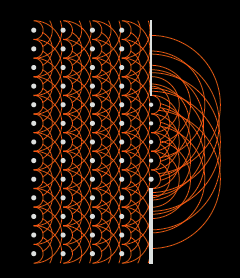


Solve RS diffraction integral with monte carlo method.

In [ ]:
num_rays=int(1e7)
planewaveapprox=False
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128)
final_image = monte_carlo_diffraction(num_rays, 
                                      final_image,
                                      sample_yx_coords,
                                      det_yx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox,
                                      sample_idx_start_yx,
                                      alias_aperture=True,
                                      aperture_px_radius=100)

Solve RS diffraction integral with monte carlo method with plane wave approximation.

In [ ]:
# planewaveapprox=True
# num_rays=int(1e6)
# final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
# final_image_pw = monte_carlo_diffraction(num_rays, 
#                                       final_image_pw,
#                                       sample_yx_indices,
#                                       sample_yx_coords,
#                                       det_yx_indices,
#                                       det_zyx_coords,
#                                       aperture_phase_shifts,
#                                       z_prop,
#                                       wavelength,
#                                       planewaveapprox)

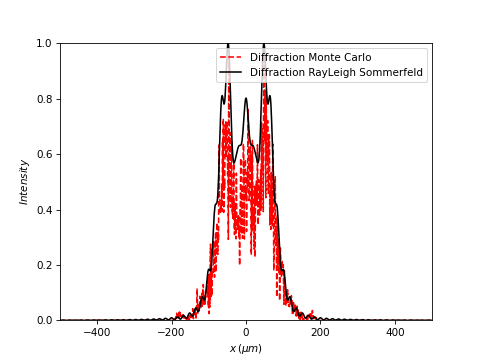

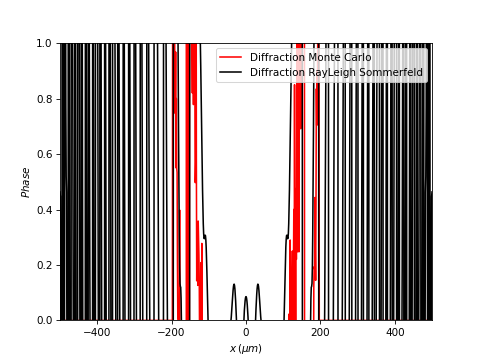

In [ ]:

fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :])**2/np.max(np.abs(final_image[0, :])**2), '--r', label='Diffraction Monte Carlo')
# ax.plot(det_yx_coords[:, 1], np.abs(final_image_pw)**2/np.max(np.abs(final_image_pw)**2), '--g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[1, 0, :], np.abs(u2.u)**2/np.max(np.abs(u2.u)**2), '-k', label='Diffraction RayLeigh Sommerfeld')
plt.legend()

fig, ax = plt.subplots()
ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[1, 0, :], np.angle(final_image[0, :]), 'r', label='Diffraction Monte Carlo')
# ax.plot(det_yx_coords[:, 1], np.angle(final_image_pw), 'g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[1, 0, :], np.angle(u2.u), '-k', label='Diffraction RayLeigh Sommerfeld')

plt.legend()


Not bad, seems to have much of the features from diffractio, now can perform same test, but in a 2D case. 

In [ ]:
aperture_diameter = 200 * um
detector_width_x = 1000 * um
detector_width_y = 1000 * um

num_px_x = 128
num_px_y = 128
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

y_indices, x_indices = np.meshgrid(np.arange(num_px_y), np.arange(num_px_x), indexing='ij')

# Combine the coordinates into a single array of (y, x) pairs
det_yx_indices = np.vstack([y_indices.ravel(), x_indices.ravel()]).T
num_pixels = int(num_px_x*num_px_y)

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
sample_yx_coords = det_yx_coords[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

z_prop = 5 * mm
wavelength = 0.638 * um

print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

Fresnel Number =  1.2539184952978056e-05


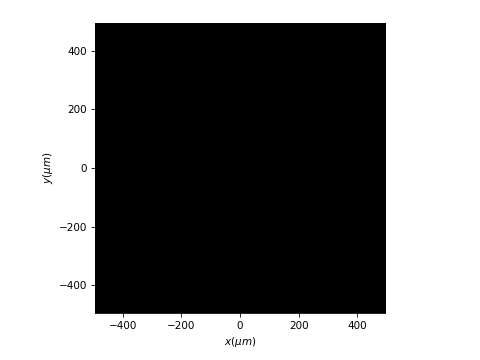

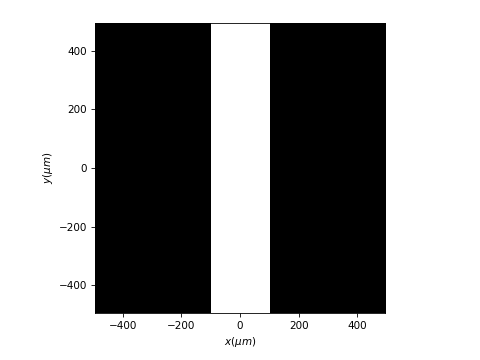

In [ ]:
u2 = diffractio_rs_aperture_2D(x0=det_zyx_coords[:num_px_x, 2], 
                               y0=det_zyx_coords[:num_px_y, 2],
                               z_prop=z_prop, 
                               aperture_width=aperture_diameter, 
                               wavelength=wavelength, 
                               draw_inputs=True)

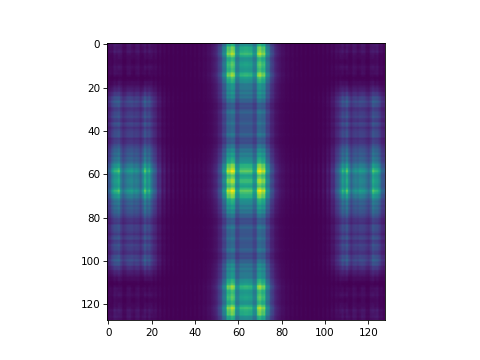

In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Diffraction RayLeigh Sommerfeld')

In [ ]:
num_rays=int(1e9)
planewaveapprox=False

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image = monte_carlo_diffraction(num_rays, 
                                      final_image,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

final_image = final_image.reshape(num_px_y, num_px_x)

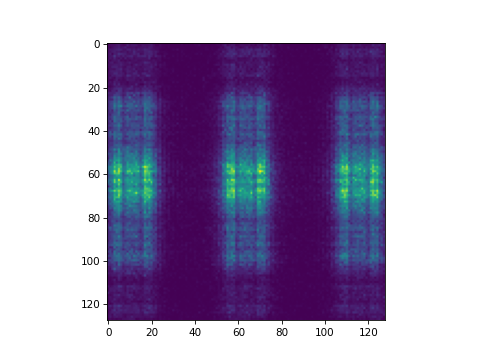

In [ ]:
fig, ax = plt.subplots()
ax.imshow((np.abs(final_image) ** 2)/np.max(np.abs(final_image) ** 2), label='Diffraction Monte Carlo')

For some reason, plane wave approximation in 2D is giving me a lot of trouble. 

In [ ]:
num_rays=int(1e5)
planewaveapprox=True

final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image_pw = monte_carlo_diffraction(num_rays, 
                                         final_image_pw,
                                         sample_yx_indices,
                                         sample_yx_coords,
                                         det_yx_indices,
                                         det_zyx_coords,
                                         aperture_phase_shifts,
                                         z_prop,
                                         wavelength,
                                         planewaveapprox)

final_image_pw = final_image_pw.reshape(num_px_y, num_px_x)

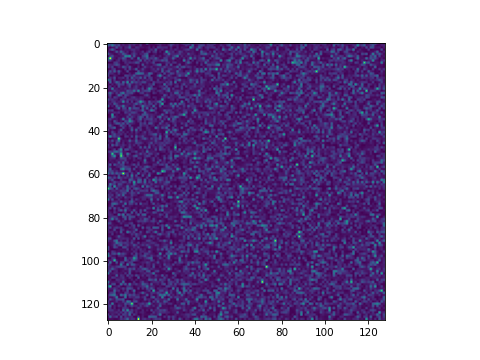

In [ ]:
fig, ax = plt.subplots()

ax.imshow((np.abs(final_image_pw) ** 2)/np.max(np.abs(final_image_pw) ** 2), label='Diffraction Monte Carlo Plane Wave')

Mixed results: 1D case seems good, and 2D case works without plane wave approximation, but with lots of rays. Plane wave approximation fails completely. Now we can text with atoms. Lets try a slice through 1 atom first. 

[                                        ] | 0% Completed | 1.51 ms

[########################################] | 100% Completed | 103.73 ms


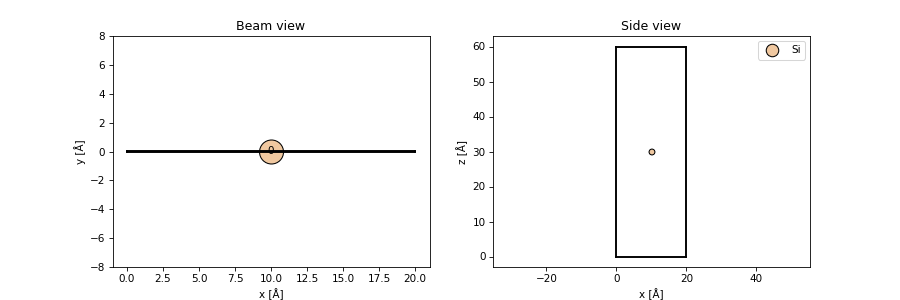

In [ ]:
import ase
import numpy as np
import abtem
import matplotlib.pyplot as plt
from typing import Tuple, NamedTuple



%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}

# atoms = ase.Atoms(
#     "Si2", positions=[(1.0, 2.0, 1.0), (3.0, 2.0, 1.0)], cell=[4, 4, 2]
# )

x1 = 1.0
atom_spacing = 3.0
x2 = x1 + atom_spacing
x_centre = 10.0
x0 = x_centre - (x1) - atom_spacing/2
z_start = 60
z_atoms = 30
z_prop = z_atoms

atoms = ase.Atoms(
    "Si1", positions=[(x_centre, 0, z_atoms)], cell=[x_centre*2, 0.05, z_start]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.05, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()




[########################################] | 100% Completed | 105.16 ms


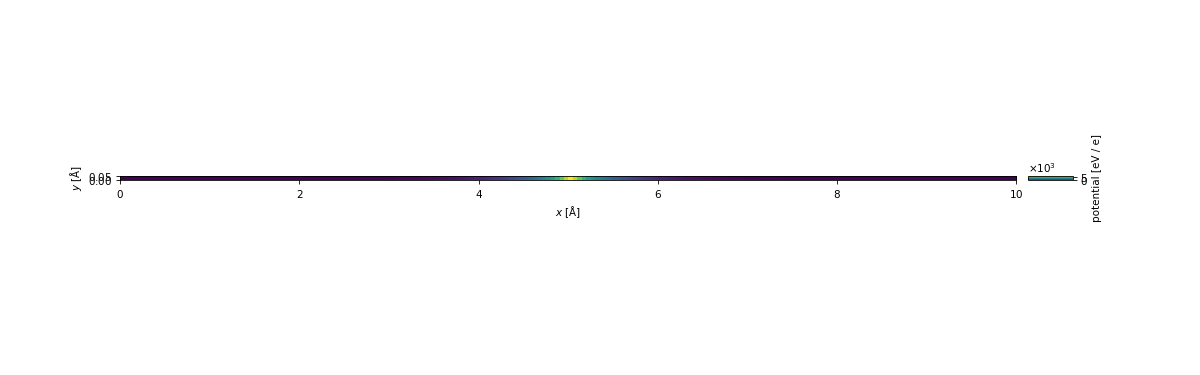

In [ ]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [ ]:
PHI_0 = 100e3
plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 0.05), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 110.07 ms

In [ ]:
from abtem.core.energy import energy2sigma, energy2wavelength



sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

print('Fresnel Number = ', 0.05/(wavelength * (z_prop**2)))

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 

sample_yx_coords = det_yx_coords

det_yx_coords = det_yx_coords.T.reshape(2, num_px_y, num_px_x)
sample_yx_coords = sample_yx_coords.T.reshape(2, num_px_y, num_px_x)

sample_phase_shift = (potential_array.array * sigma).reshape(num_px_y, num_px_x)


Fresnel Number =  0.0015009187413531474


In [ ]:
planewaveapprox=False
num_rays=int(1e7)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128)
atom_image = monte_carlo_diffraction(num_rays, 
                                      atom_image,
                                      sample_yx_coords,
                                      det_yx_coords,
                                      sample_phase_shift,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox,
                                      alias_aperture=False,
                                      aperture_px_radius=50)

In [ ]:
planewaveapprox=True
num_rays=int(1e7)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                    atom_image_pw,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z_prop,
                                    wavelength,
                                    planewaveapprox)

IndexError: tuple index out of range

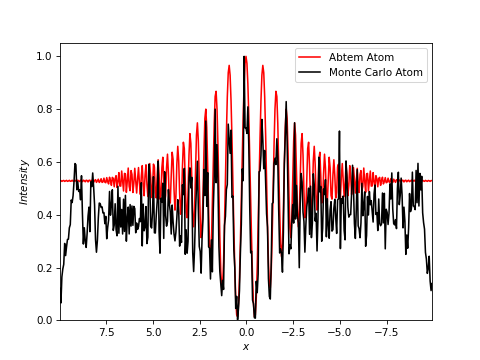

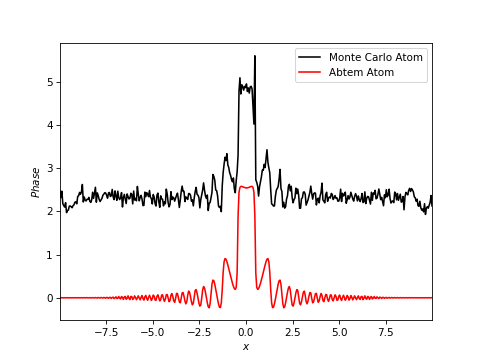

In [ ]:
fig, ax = plt.subplots()
ax.plot(det_yx_coords[1, 0, :], np.abs(complex_image.array)**2/np.max(np.abs(complex_image.array)**2), '-r', label='Abtem Atom')
ax.plot(det_yx_coords[1, 0, :], np.abs(atom_image[0, :])**2/np.max(np.abs(atom_image[0, :])**2), '-k', label='Monte Carlo Atom')
# ax.plot(det_yx_coords[:, 1], np.abs(atom_image_pw)**2/np.max(np.abs(atom_image_pw)**2), '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[1, 0, -1], right=det_yx_coords[1, 0, 1])
ax.set_ylim(bottom=0)
plt.legend()

monte_carlo_phase = np.angle(atom_image[0, :])
monte_carlo_phase = np.unwrap(monte_carlo_phase)

# monte_carlo_phase_pw = np.angle(atom_image_pw)
# monte_carlo_phase_pw = np.unwrap(monte_carlo_phase)


fig, ax = plt.subplots()
ax.plot(det_yx_coords[1, 0, :], monte_carlo_phase, '-k', label='Monte Carlo Atom')
ax.plot(det_yx_coords[1, 0, :], np.angle(complex_image.array), '-r', label='Abtem Atom')
# ax.plot(det_yx_coords[:, 1], monte_carlo_phase_pw, '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
# ax.set_ylim(bottom=0)
plt.legend()

Result for single atom seems to work for plane wave approximation, and without it. Now try a single atom in 2D. 

[                                        ] | 0% Completed | 1.20 ms

[########################################] | 100% Completed | 102.20 ms


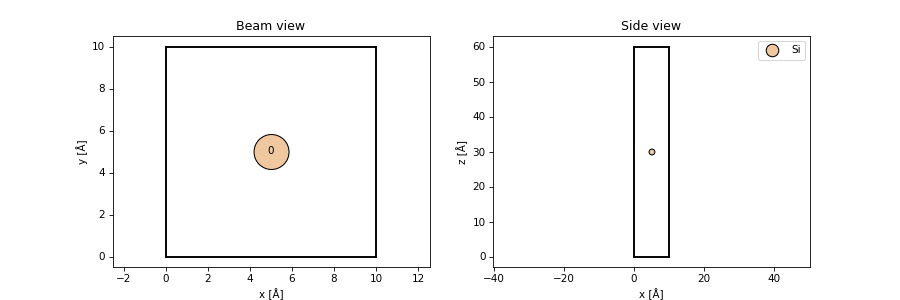

In [ ]:
atoms = ase.Atoms(
    "Si1", positions=[(x_centre, x_centre, z_atoms)], cell=[x_centre*2, x_centre*2, z_start]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.1, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()

[########################################] | 100% Completed | 102.36 ms

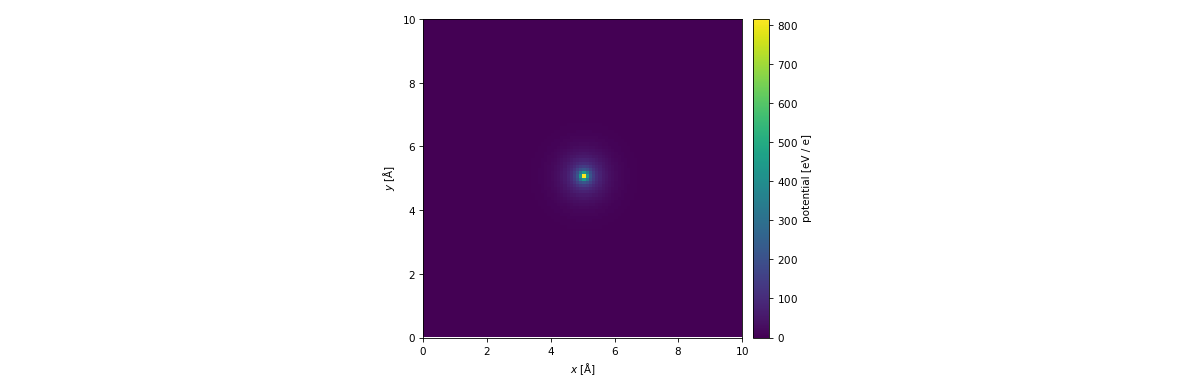

In [ ]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [ ]:
plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 103.33 ms


In [ ]:
from abtem.core.energy import energy2sigma, energy2wavelength

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shifts = (potential_array.array * sigma).ravel()

In [ ]:
planewaveapprox=False
num_rays=int(1e9)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_diffraction(num_rays, 
                                     atom_image,
                                     sample_yx_indices,
                                     sample_yx_coords,
                                     det_yx_indices,
                                     det_zyx_coords,
                                     sample_phase_shifts,
                                     z_prop,
                                     wavelength,
                                     planewaveapprox)

atom_image = atom_image.reshape(num_px_y, num_px_x)

In [ ]:
planewaveapprox=True
num_rays=int(1e5)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                        atom_image_pw,
                                        sample_yx_indices,
                                        sample_yx_coords,
                                        det_yx_indices,
                                        det_zyx_coords,
                                        sample_phase_shifts,
                                        z_prop,
                                        wavelength,
                                        planewaveapprox)
atom_image_pw = atom_image_pw.reshape(num_px_y, num_px_x)

Text(0.5, 1.0, 'Abtem')

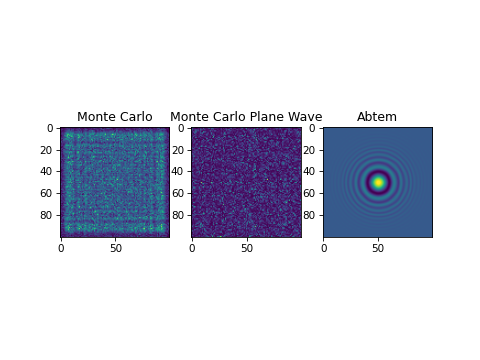

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.abs(atom_image)**2)
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.abs(atom_image_pw)**2)
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.abs(complex_image.array)**2)
ax[2].set_title('Abtem')

Text(0.5, 1.0, 'Abtem')

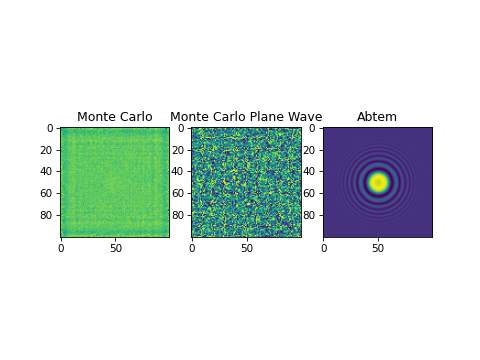

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.angle(atom_image))
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.angle(atom_image_pw))
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.angle(complex_image.array))
ax[2].set_title('Abtem')



Not a great result, The big difference could be because of some tampering abtem does with an aperture to cut off artefacts in fourier space. Plane wave approximation again fails completely in the 2D case. Results could be different also because abtem uses fresnel propagation, whereas we don't but I'm not convinced that explains such a big difference in the 2D case. 

Let's try with more atoms also in one slice. 

[                                        ] | 0% Completed | 1.59 ms

[########################################] | 100% Completed | 102.58 ms


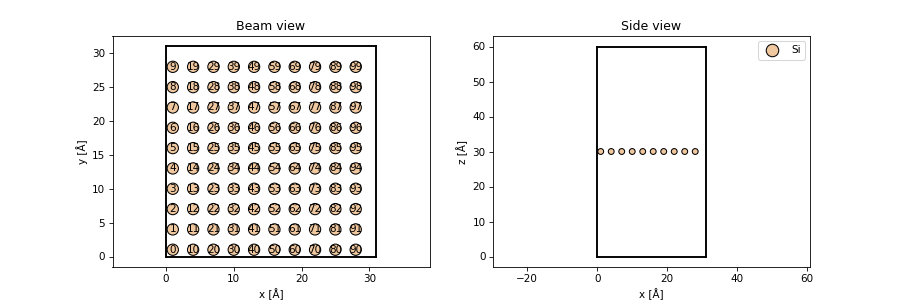

In [ ]:
num_atoms_x = 10 
num_atoms_y = 10
atom_spacing = 3.0
x_start = 1.0
y_start = 1.0

# Create an empty Atoms object
atoms = ase.Atoms('Si0', cell=[x_start + num_atoms_x* atom_spacing, y_start + num_atoms_y* atom_spacing, z_start])

# Adding atoms in a row
for i in range(num_atoms_x):
    for j in range(num_atoms_y):
        x_position = x_start + i * atom_spacing
        y_position = y_start + j * atom_spacing
        atoms += ase.Atoms('Si1', positions=[(x_position, y_position, z_atoms)])


# Configure potential
phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.4, projection="infinite", slice_thickness=30)
potential_array = potential.build().project().compute()


[########################################] | 100% Completed | 104.05 ms


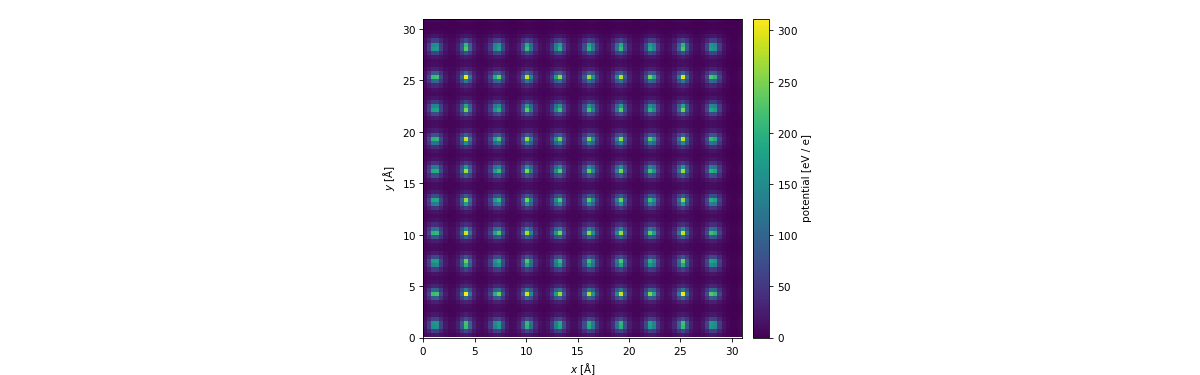

In [ ]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [ ]:

plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 103.39 ms


In [ ]:
from abtem.core.energy import energy2sigma, energy2wavelength

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shifts = (potential_array.array * sigma).ravel()

In [ ]:
planewaveapprox=False
num_rays=int(1e10)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_diffraction(num_rays, 
                                     atom_image,
                                     sample_yx_indices,
                                     sample_yx_coords,
                                     det_yx_indices,
                                     det_zyx_coords,
                                     sample_phase_shifts,
                                     z_prop,
                                     wavelength,
                                     planewaveapprox)

atom_image = atom_image.reshape(num_px_y, num_px_x)


In [ ]:
planewaveapprox=True
num_rays=int(1e5)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                        atom_image_pw,
                                        sample_yx_indices,
                                        sample_yx_coords,
                                        det_yx_indices,
                                        det_zyx_coords,
                                        sample_phase_shifts,
                                        z_prop,
                                        wavelength,
                                        planewaveapprox)
atom_image_pw = atom_image_pw.reshape(num_px_y, num_px_x)

Text(0.5, 1.0, 'Abtem')

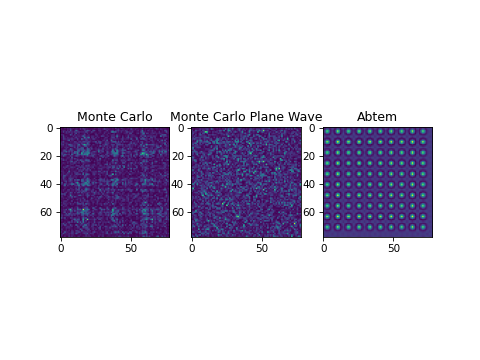

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.abs(atom_image)**2)
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.abs(atom_image_pw)**2)
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.abs(complex_image.array)**2)
ax[2].set_title('Abtem')

Another odd result. Not sure where to go from here. The square patterns in the monte carlo without plane wave are interesting. 